In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import catboost as catb
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
pd.options.display.max_columns = 100

In [2]:
df_train  = pd.read_csv('B2_train.csv')
df_test = pd.read_csv('B2_test.csv')

In [3]:
TARGET_NAME = 'Credit Default'
BASE_DATASET_PATH = 'df_train_prep.csv'
PREP_DATASET_PATH = 'df_train_prep_new.csv'

In [4]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
df_train.shape

(7500, 17)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

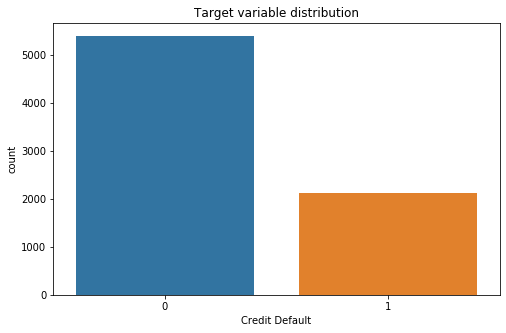

In [7]:
#обзор целевой переменной
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

In [8]:
#обзор  номинативных  признаков
for col_name in df_train.select_dtypes(include='object').columns:
    print(str(col_name)+'   \n'+str(df_train[col_name].value_counts()))
    print('-' * 80)

Home Ownership   
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
--------------------------------------------------------------------------------
Years in current job   
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
--------------------------------------------------------------------------------
Purpose   
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy 

In [9]:
#обзор категориальных признаков
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [10]:
len(df_train.loc[df_train['Annual Income'].isnull(), :].index)

1557

In [11]:
#предположу, что такое кол-во пропусков т.к. данные не заполнены, заменю пропуски на медиану
def annual_income_n(df):
    df['Annual Income'] = df['Annual Income'].fillna(df['Annual Income'].median())
    return df

In [12]:
len(df_train.loc[df_train['Years in current job'].isnull(), :].index)

371

In [13]:
#заменим пропуски на наиболее часто встречающиеся значение
def years_in_current_job_n(df):
    df.loc[df['Years in current job'].isnull(), 'Years in current job'] = df['Years in current job'].mode()[0]
    return df

In [14]:
len(df_train.loc[df_train['Months since last delinquent'].isnull(), :].index)

4081

In [15]:
#кол-во пропусков больше 50%, посмотрим какие значения встречаются и в каком кол-ве
df_train['Months since last delinquent'].value_counts()

14.0     76
29.0     71
8.0      68
33.0     68
13.0     65
         ..
86.0      1
92.0      1
118.0     1
84.0      1
91.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [16]:
#предположу, что незаполненные значения это отсутствие просроченных платежей. Если вместо пропусков ставить большое значение, 
# например 10000 месяцев с последнего просроченного платежа то получается вброс. Принимаю решение удалить данный признак
def months_since_last_delinquent_n(df):
    df = df.drop('Months since last delinquent', axis=1)
    return df

In [17]:
len(df_train.loc[df_train['Bankruptcies'].isnull(), :].index)

14

In [18]:
#заменим пропуски на наиболее часто встречающиеся значение
def bankruptcies_n(df):
    df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = df['Bankruptcies'].mode()[0]
    return df

In [19]:
len(df_train.loc[df_train['Credit Score'].isnull(), :].index)

1557

In [20]:
CS = df_train['Credit Score'].unique()
CS.sort(axis=0)
CS

array([ 585.,  586.,  588.,  589.,  590.,  591.,  593.,  594.,  597.,
        598.,  599.,  601.,  602.,  604.,  606.,  607.,  608.,  609.,
        610.,  611.,  612.,  613.,  614.,  615.,  616.,  617.,  618.,
        619.,  620.,  621.,  622.,  624.,  625.,  626.,  627.,  628.,
        629.,  630.,  631.,  632.,  633.,  634.,  635.,  636.,  637.,
        638.,  639.,  640.,  642.,  643.,  644.,  645.,  646.,  647.,
        648.,  649.,  650.,  651.,  652.,  653.,  654.,  655.,  656.,
        657.,  658.,  659.,  660.,  661.,  662.,  663.,  664.,  665.,
        666.,  667.,  668.,  669.,  670.,  671.,  672.,  673.,  674.,
        675.,  676.,  677.,  678.,  679.,  680.,  681.,  682.,  683.,
        684.,  685.,  686.,  687.,  688.,  689.,  690.,  691.,  692.,
        693.,  694.,  695.,  696.,  697.,  698.,  699.,  700.,  701.,
        702.,  703.,  704.,  705.,  706.,  707.,  708.,  709.,  710.,
        711.,  712.,  713.,  714.,  715.,  716.,  717.,  718.,  719.,
        720.,  721.,

In [21]:
#кроме пропущенных значений так же присутсвуют очень большие значения, в то время как max значение кредитного рейтинга не может 
#быть больше чем 999. Похоже на ошибку ввода, разделим на 10 и введем новые значения
def credit_score(df):
    df.loc[df['Credit Score'].isnull(), 'Credit Score'] = df['Credit Score'].median()
    df.loc[(df['Credit Score'] > 999), 'Credit Score'] = df['Credit Score'] / 10
    return df

In [22]:
df_train.loc[df_train['Current Credit Balance'] > 5000000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4769,Home Mortgage,3739960.0,9 years,0.0,7.0,22.8,26343328.0,0.0,NaN,0.0,home improvements,Short Term,757834.0,6506797.0,38023.0,703.0,0


In [23]:
#данное значение похоже на выброс, замнеим на среднее
def current_credit_balance(df):
    df.loc[(df['Current Credit Balance'] > 5000000), 'Current Credit Balance'] = df['Current Credit Balance'].mean()
    return df

In [24]:
df_train.loc[df_train['Monthly Debt'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
780,Home Mortgage,867749.0,10+ years,0.0,2.0,16.5,0.0,0.0,66.0,0.0,home improvements,Short Term,75350.0,0.0,0.0,704.0,0
1643,Rent,NaN,9 years,0.0,3.0,10.0,0.0,0.0,NaN,0.0,other,Short Term,332156.0,0.0,0.0,NaN,1
3219,Home Mortgage,NaN,10+ years,0.0,3.0,18.5,0.0,0.0,NaN,0.0,debt consolidation,Short Term,79200.0,0.0,0.0,NaN,0
3496,Rent,233567.0,1 year,0.0,7.0,11.7,0.0,0.0,0.0,NaN,educational expenses,Short Term,210166.0,0.0,0.0,746.0,0
4165,Rent,1254513.0,10+ years,0.0,6.0,23.4,0.0,0.0,60.0,0.0,take a trip,Short Term,99999999.0,0.0,0.0,748.0,0
7124,Rent,NaN,1 year,0.0,4.0,11.0,0.0,0.0,50.0,0.0,debt consolidation,Short Term,134024.0,0.0,0.0,NaN,0


In [25]:
#как видно у людей с суммой ежемесячного платежа есть задолженность, заменим на медиану
def monthly_debt_n(df):
    df.loc[df['Monthly Debt'] == 0, 'Monthly Debt'] = df['Monthly Debt'].median()
    return df

In [26]:
df_train = annual_income_n(df_train)
df_train = years_in_current_job_n(df_train)
df_train = months_since_last_delinquent_n(df_train)
df_train = bankruptcies_n(df_train)
df_train = credit_score(df_train)
df_train = current_credit_balance(df_train)
df_train = monthly_debt_n(df_train)

In [27]:
df_train.to_csv(BASE_DATASET_PATH, index=False, encoding='utf-8')

In [28]:
def ID(df):
    df['ID'] = df.index.tolist()
    return df

In [29]:
def dummies(df):
    for cat_colname in df.select_dtypes(include='object').columns[:]:
        df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
    df.rename(columns={'Years in current job_< 1 year': 'Years in current job_less 1 year'}, inplace=True)
    return df

In [30]:
df_train = ID(df_train)
df_train = dummies(df_train)

In [31]:
df_train.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

In [32]:
df_base = pd.read_csv(BASE_DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)

In [33]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

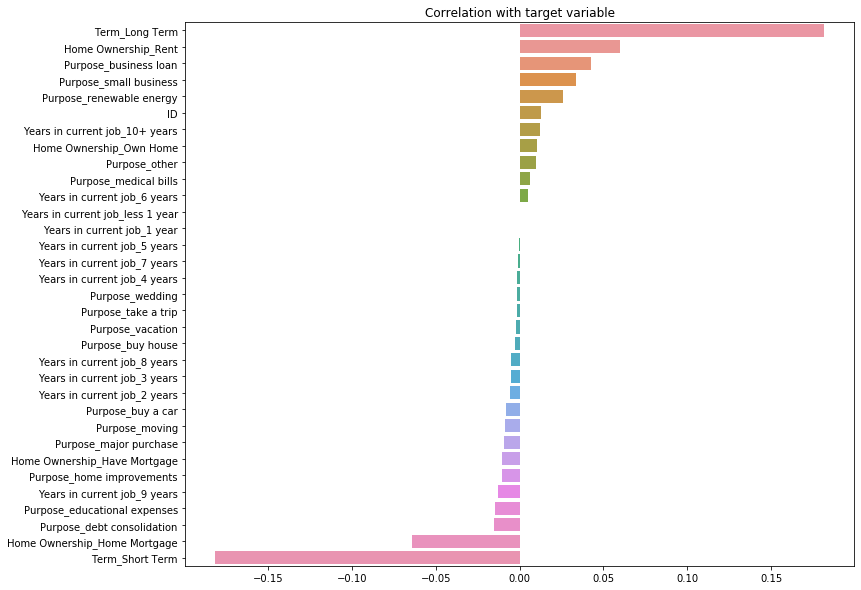

In [34]:
corr_with_target = df[NEW_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(12, 10))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [35]:
NUM_FEATURE_NAMES = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History','Maximum Open Credit',
                     'Number of Credit Problems','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']

NEW_FEATURE_NAMES = ['Home Ownership_Home Mortgage','Home Ownership_Rent','Years in current job_4 years',
                     'Years in current job_5 years','Years in current job_9 years','Purpose_business loan',
                     'Purpose_debt consolidation','Purpose_small business','Term_Long Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

In [36]:
SELECTED_FEATURE_NAMES

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Rent',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_9 years',
 'Purpose_business loan',
 'Purpose_debt consolidation',
 'Purpose_small business',
 'Term_Long Term']

In [37]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)

In [38]:
df_test = annual_income_n(df_test)
df_test = years_in_current_job_n(df_test)
df_test = months_since_last_delinquent_n(df_test)
df_test = bankruptcies_n(df_test)
df_test = credit_score(df_test)
df_test = current_credit_balance(df_test)
df_test = monthly_debt_n(df_test)
df_test = ID(df_test)
df_test = dummies(df_test)

In [39]:
TEST_FEATURE_NAMES_SELECTED = SELECTED_FEATURE_NAMES

In [40]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,ID,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_less 1 year,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,Rent,1178475.0,4 years,0.0,9.0,12.5,220968.0,0.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,726.0,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,4,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [41]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [42]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [43]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3795
1    2910
Name: Credit Default, dtype: int64

In [44]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [45]:
final_model = catb.CatBoostClassifier(class_weights=[1, 1.5], n_estimators=1200, max_depth=7,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_valid_pred = final_model.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      3795
           1       0.85      0.98      0.91      2910

    accuracy                           0.92      6705
   macro avg       0.92      0.92      0.92      6705
weighted avg       0.93      0.92      0.92      6705

VALID

              precision    recall  f1-score   support

           0       0.79      0.68      0.73      1592
           1       0.42      0.56      0.48       658

    accuracy                           0.65      2250
   macro avg       0.61      0.62      0.61      2250
weighted avg       0.68      0.65      0.66      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1084  508
1                287  371


In [46]:
predicted = final_model.predict(df_test[TEST_FEATURE_NAMES_SELECTED])

In [47]:
pred = pd.DataFrame({'Credit Default': pd.Series(predicted, dtype='int64')})

In [48]:
pred.to_csv('AV_predictions.csv', index=False)